<a href="https://colab.research.google.com/github/IsaacFigNewton/Cyclic-Decision-Graph-Generator/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

In [2]:
#Number of neighbors to use in KNN estimation
n_neighbors = 1

# minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
alpha = 1e-9

# Prepare for k-fold cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    'A': 'red',
    'B': 'blue'
}
class_map = {
    'A': 0,
    'B': 1
}

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

In [3]:
# class FeatureProbabilityDistributionEstimator(ClassifierMixin, BaseEstimator):

#     def __init__(self, alpha = 1e-9, n_neighbors = 1):
#         self.alpha = alpha
#         self.n_neighbors = n_neighbors

#     def fit(self, X, y):
#         # Check that X and y have correct shape
#         X, y = check_X_y(X, y)

#         self.X_ = X
#         self.y_ = y

#         # Return the classifier
#         return self

#     def predict(self, X):
#         # Check if fit has been called
#         check_is_fitted(self)

#         # Input validation
#         X = check_array(X)

#         closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
#         return self.y_[closest]

## Main Functions

In [4]:
def get_prob_distribution(dataset, X, y):
  classes = dataset[y[0]].unique()
  prior_class_probabilities = {class_value: get_prior_probability(class_value, dataset) for class_value in classes}
  # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
  feature_distribution = {class_value: {feature_value: dict() for feature_value in X} for class_value in classes}
  # create a dict to hold the global probabilities of every unique value in every feature
  global_unique_val_probabilities = {feature_value: dict() for feature_value in X}
  # create a dict to store PMFs for each feature and unique value
  pmf_store = {class_value: {feature_value: defaultdict() for feature_value in X} for class_value in classes}


  # Calculating and storing PMFs
  for feature in X:

      # Get unique values for the current feature
      unique_values = dataset[feature].unique()
      # Calculate the weighted probability for each unique value
      for unique_value in unique_values:

          # Calculate the probability distribution for the current feature and unique value
          prob_distribution, p_unique = calculate_weighted_prob(unique_value, feature, dataset, classes)
          # print(f"Weighted class probabilities for {feature} = {unique_value}: {prob_distribution}")

          # Add the weighted probabilities of the unique value to the feature distribution set
          for class_value in classes:
              feature_distribution[class_value][feature][unique_value] = prob_distribution[class_value]

              # Create a KNN for the current feature
              pmf = create_pmf_using_knn(class_value, feature, feature_distribution)
              # print(f"PMF for {feature} = {unique_value}: {pmf}")

              # Store the KNN for the current feature and class
              pmf_store[class_value][feature] = pmf

          # Store the probability distribution for the current feature and unique value
          global_unique_val_probabilities[feature][unique_value] = p_unique


  # print("Feature Distribution:")
  # print_tree(feature_distribution)
  # print()
  # print("Prior Class Probabilities:")
  # print_tree(prior_class_probabilities)
  # print()
  # print("Prior Feature Value Probabilities:")
  # print_tree(global_unique_val_probabilities)
  # print()
  # print("PMF Store:")
  # print_tree(pmf_store)


  return prior_class_probabilities, feature_distribution, pmf_store

In [5]:
# Function to calculate probability distribution
def calculate_weighted_prob(unique_value, feature, dataset, classes):
    weighted_prob = {}

    # Calculate the probability of the unique value in the dataset as a whole
    p_unique = (dataset[feature] == unique_value).sum() / len(dataset)
    # print(f"P({feature} = {unique_value}) = \t{p_unique}")

    for class_value in classes:
        # Filter the dataset for the current class and feature value
        class_data = dataset[dataset[y[0]] == class_value]

        p_unique_given_class = (class_data[feature] == unique_value).sum() / len(class_data)

        # print(f"P({feature} = {unique_value} | class = {class_value}) = \t{p_unique_given_class}")

        # Avoid division by zero
        if p_unique > 0:
            weighted_prob[class_value] = p_unique_given_class / p_unique
        else:
            # No data for this unique value
            weighted_prob[class_value] = alpha

    return weighted_prob, p_unique

## Helper functions

In [6]:
# Function to create PMF using KNN
def create_pmf_using_knn(class_value, feature, prob_distribution):
    # print(f"Creating KNN for class {class_value} and feature {feature}")
    # print_tree(prob_distribution[class_value][feature])

    # Get the values for the current feature and class
    values = np.array(list(prob_distribution[class_value][feature].keys()))\
                .reshape(-1, 1)
    # Get the weighted probabilities for the current feature and class
    probabilities = np.array(list(prob_distribution[class_value][feature].values()))

    # Create a kernel density estimator using Gaussian kernel
    knn = KNeighborsRegressor(n_neighbors = n_neighbors).fit(values, probabilities)

    return knn


In [7]:
# Function to calculate P(class | feature1_value /\ feature2_value /\ …)
def calculate_class_probabilities(feature_values, prior_probs, pmf_store):
    class_probabilities = {class_value: 1 for class_value in prior_probs.keys()}

    for class_value in prior_probs.keys():
        # print(f"Calculating datapoint's probability for class {class_value}")

        likelihood = 1
        for feature, value in feature_values.items():
            # print(f"Getting likelihood for {value} given {feature}")
            feature_likelihood = pmf_store[class_value][feature].predict(np.array([[value]]))
            # print(f"Likelihood for {value} given {feature} = {feature_likelihood}")
            # Accumulate features' weighted probabilities
            likelihood *= feature_likelihood

        # Get final class probability
        class_probability = likelihood * prior_probs[class_value]

        # print(f"P({class_value} | {feature_values}) = \t{class_probability}")
        class_probabilities[class_value] = class_probability

    return class_probabilities

In [8]:
# Function to get prior probability of the class
def get_prior_probability(class_value, dataset):
    return (dataset[y[0]] == class_value).sum() / len(dataset)

## Utility

In [9]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

# Import and Clean Dataset

In [10]:
# Example usage:
# Sample dataset
data = {
    'Feature 1': [1, 2, 2, 3, 3, 3],
    'Feature 2': [10, 15, 10, 20, 25, 20],
    'Class': ['A', 'A', 'B', 'B', 'A', 'B']
}
dataset = pd.DataFrame(data)
X = ['Feature 1', 'Feature 2']
y = ["Class"]

dataset.head()

,Feature 1,Feature 2,Class
0,1,10,A
1,2,15,A
2,2,10,B
3,3,20,B
4,3,25,A


# Data Exploration

## Preprocessing

In [11]:
# Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
classes = dataset[y[0]].unique()
feature_distribution_x_y = {
                          class_value: {feature_value: (list(feature_distribution[class_value][feature_value].keys()),\
                                                        list(feature_distribution[class_value][feature_value].values()))\
                                for feature_value in X\
                          } for class_value in classes
}

print_tree(feature_distribution_x_y)

A
    Feature 1
        ([1, 2, 3], [2.0, 1.0, 0.6666666666666666])
    Feature 2
        ([10, 15, 20, 25], [1.0, 2.0, 0.0, 2.0])
B
    Feature 1
        ([1, 2, 3], [0.0, 1.0, 1.3333333333333333])
    Feature 2
        ([10, 15, 20, 25], [1.0, 0.0, 2.0, 0.0])


In [12]:
# Parse the loose JSON representation into a dataframe

# Initialize an empty list to store the rows
rows = []

# Iterate through the dictionary to extract the data
for class_value, features in feature_distribution_x_y.items():
    for feature, (x_values, y_values) in features.items():
        # Create a DataFrame for the current feature
        df_feature = pd.DataFrame({
            'Class': class_value,
            'Feature': feature,
            'Feature Value': x_values,
            'Weighted Probability': y_values
        })
        # Append the DataFrame to the rows list
        rows.append(df_feature)

# Concatenate all rows into a single DataFrame
df = pd.concat(rows, ignore_index=True)

df

,Class,Feature,Feature Value,Weighted Probability
0,A,Feature 1,1,2.000000
1,A,Feature 1,2,1.000000
2,A,Feature 1,3,0.666667
3,A,Feature 2,10,1.000000
4,A,Feature 2,15,2.000000
5,A,Feature 2,20,0.000000
6,A,Feature 2,25,2.000000
7,B,Feature 1,1,0.000000
8,B,Feature 1,2,1.000000
9,B,Feature 1,3,1.333333


In [13]:
feature_1_df = df[df["Feature"] == "Feature 1"]
feature_2_df = df[df["Feature"] == "Feature 2"]

feature_1_df

,Class,Feature,Feature Value,Weighted Probability
0,A,Feature 1,1,2.000000
1,A,Feature 1,2,1.000000
2,A,Feature 1,3,0.666667
7,B,Feature 1,1,0.000000
8,B,Feature 1,2,1.000000
9,B,Feature 1,3,1.333333


## Figures

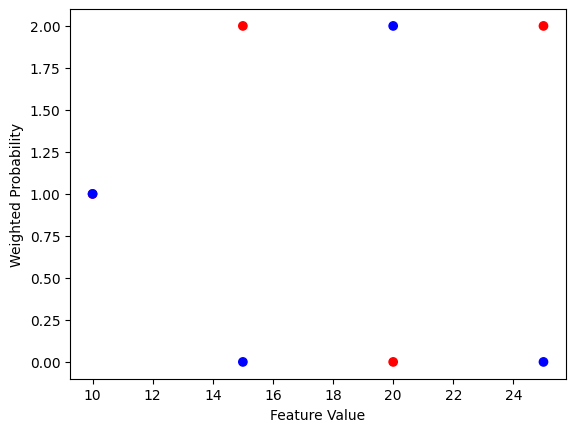

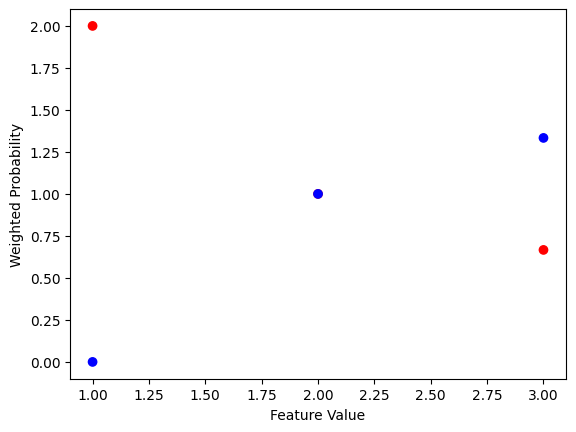

In [14]:
# Create a scatter plot of the features' probability distribution
plt.scatter(feature_2_df['Feature Value'], feature_2_df['Weighted Probability'], c=feature_2_df[y[0]].map(colormap))

# Add labels and title
plt.xlabel('Feature Value')
plt.ylabel('Weighted Probability')
plt.show()

plt.scatter(feature_1_df['Feature Value'], feature_1_df['Weighted Probability'], c=feature_1_df[y[0]].map(colormap))

# Add labels and title
plt.xlabel('Feature Value')
plt.ylabel('Weighted Probability')
plt.show()

# Cross Validation Against other Models

In [12]:
# df.dropna(inplace=True)

In [13]:
dataset.head()

,Feature 1,Feature 2,Class
0,1,10,A
1,2,15,A
2,2,10,B
3,3,20,B
4,3,25,A


## Sklearn DT Classifier

In [14]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [15]:
# Split the data into training and test sets
fold = 1
for train_index, test_index in kf.split(dataset):
    print(f"Fold {fold}")

    # Split the data
    train_data = dataset.iloc[train_index]
    print(train_data.head())
    test_data = dataset.iloc[test_index]

    # Train the pipeline
    pipeline.fit(train_data[X], train_data[y[0]])

    # Predict and evaluate the model
    y_true = test_data[y]
    y_pred = pipeline.predict(test_data[X])

    # Calculate metrics using sklearn
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # # Print the decision tree
    # print_tree(tree)
    # print()

    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print()

    # Increment the fold index
    fold += 1

Fold 1
   Feature 1  Feature 2 Class
2          2         10     B
3          3         20     B
4          3         25     A
Fold 2
   Feature 1  Feature 2 Class
0          1         10     A
1          2         15     A
5          3         20     B



Average Scores:
Precision: 0.2222 (+/- 0.1111)
Recall: 0.3333 (+/- 0.0000)
Accuracy: 0.3333 (+/- 0.0000)
F1 Score: 0.2500 (+/- 0.0833)


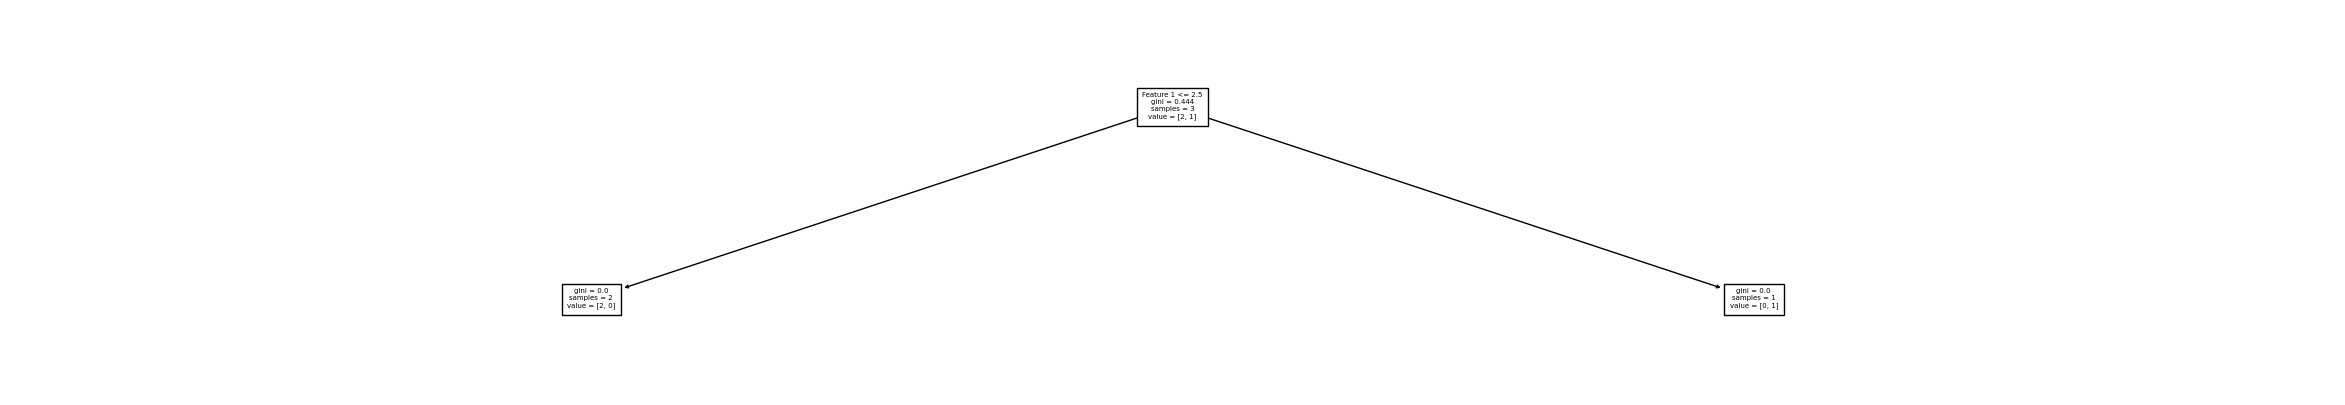

In [16]:
# Print the decision tree

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['classifier'],
               max_depth=5,
               feature_names=X,
               fontsize=5,
               ax=ax)

# Save average scores
avg_scores = dict()
avg_scores["sklearn"] = {
    "precision": np.mean(precisions),
    "recall": np.mean(recalls),
    "accuracy": np.mean(accuracies),
    "f1": np.mean(f1_scores),
    "std_precision": np.std(precisions),
    "std_recall": np.std(recalls),
    "std_accuracy": np.std(accuracies),
    "std_f1": np.std(f1_scores),
}

# Print average scores
print()
print("Average Scores:")
print(f"Precision: {avg_scores['sklearn']['precision']:.4f} (+/- {avg_scores['sklearn']['std_precision']:.4f})")
print(f"Recall: {avg_scores['sklearn']['recall']:.4f} (+/- {avg_scores['sklearn']['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['sklearn']['accuracy']:.4f} (+/- {avg_scores['sklearn']['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['sklearn']['f1']:.4f} (+/- {avg_scores['sklearn']['std_f1']:.4f})")

## Custom Approach

In [17]:
f1_by_k = dict()

In [18]:
# Perform k-fold cross-validation on different values of n_neighbors
for k in range(1, 2):
    n_neighbors = k
    print(f"n_neighbors = {n_neighbors}")
    fold = 1
    for train_index, test_index in kf.split(dataset):
        print(f"Fold {fold}")

        # Split the data
        train_data = dataset.iloc[train_index]
        test_data = dataset.iloc[test_index]

        # Estimate the probability mass function
        prior_class_probabilities, feature_distribution, pmf_store = get_prob_distribution(train_data, X, y)

        for i in range(len(test_data)):
            datapoint = test_data\
                            .iloc[i][X]\
                            .to_dict()
            class_probabilities = calculate_class_probabilities(datapoint, prior_class_probabilities, pmf_store)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            test_data.at[test_data.index[i], "Predicted Class"] = predicted_class

        # train_data.dropna(inplace=True)
        # test_data.dropna(inplace=True)

        # Make predictions
        y_true = test_data[y[0]].map(class_map).dropna()
        y_pred = test_data['Predicted Class'].map(class_map).dropna()

        # # Print the true and predicted classes
        # print("True Classes:")
        # print(y_true.head())
        # print("Predicted Classes:")
        # print(y_pred.head())

        # Calculate metrics using sklearn
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1)

        # # Print the decision tree
        # print_tree(tree)
        # print()

        # print(f"Precision: {precision:.4f}")
        # print(f"Recall: {recall:.4f}")
        # print(f"Accuracy: {accuracy:.4f}")
        # print(f"F1 Score: {f1:.4f}")
        # print()

        # Increment the fold index
        fold += 1
        print("\n")

    # Save the n_neighbors value and evaluation metrics for this iteration
    #   if this value provides the highest f1 score
    mean_f1 = np.mean(f1_scores)
    if avg_scores.get("custom") is None:
        avg_scores["custom"] = {
            "n_neighbors": k,
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "accuracy": np.mean(accuracies),
            "f1": mean_f1,
            "std_precision": np.std(precisions),
            "std_recall": np.std(recalls),
            "std_accuracy": np.std(accuracies),
            "std_f1": np.std(f1_scores)
        }
    elif avg_scores["custom"]["f1"] < mean_f1:
        avg_scores["custom"] = {
            "n_neighbors": k,
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "accuracy": np.mean(accuracies),
            "f1": mean_f1,
            "std_precision": np.std(precisions),
            "std_recall": np.std(recalls),
            "std_accuracy": np.std(accuracies),
            "std_f1": np.std(f1_scores)
        }

    # Save the k and f1 values for this iteration
    f1_by_k[k] = mean_f1

f1_by_k = pd.DataFrame(f1_by_k.items(), columns=["k", "f1"])

n_neighbors = 1
Fold 1


Fold 2




<ipython-input-18-fc30b095fdd9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.at[test_data.index[i], "Predicted Class"] = predicted_class
<ipython-input-18-fc30b095fdd9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.at[test_data.index[i], "Predicted Class"] = predicted_class


### Results

In [19]:
print(f1_by_k.head())

   k    f1
0  1  0.25


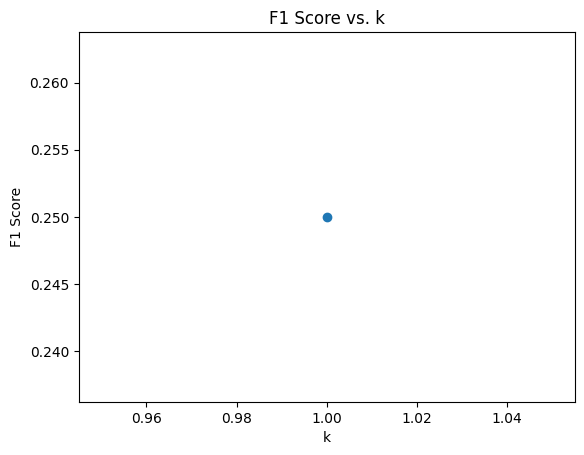

In [20]:
plt.plot(f1_by_k["k"], f1_by_k["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. k")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [21]:
print(avg_scores)

{'sklearn': {'precision': 0.2222222222222222, 'recall': 0.3333333333333333, 'accuracy': 0.3333333333333333, 'f1': 0.25, 'std_precision': 0.1111111111111111, 'std_recall': 0.0, 'std_accuracy': 0.0, 'std_f1': 0.08333333333333333}, 'custom': {'n_neighbors': 1, 'precision': 0.2222222222222222, 'recall': 0.3333333333333333, 'accuracy': 0.3333333333333333, 'f1': 0.25, 'std_precision': 0.1111111111111111, 'std_recall': 0.0, 'std_accuracy': 0.0, 'std_f1': 0.08333333333333333}}


In [22]:
# Print average scores
print()
print("Average Scores for Optimal k:")
print(f"n_neighbors = {avg_scores['custom']['n_neighbors']}")
print(f"Precision: {avg_scores['custom']['precision']:.4f} (+/- {avg_scores['custom']['std_precision']:.4f})")
print(f"Recall: {avg_scores['custom']['recall']:.4f} (+/- {avg_scores['custom']['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['custom']['accuracy']:.4f} (+/- {avg_scores['custom']['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['custom']['f1']:.4f} (+/- {avg_scores['custom']['std_f1']:.4f})")


Average Scores for Optimal k:
n_neighbors = 1
Precision: 0.2222 (+/- 0.1111)
Recall: 0.3333 (+/- 0.0000)
Accuracy: 0.3333 (+/- 0.0000)
F1 Score: 0.2500 (+/- 0.0833)


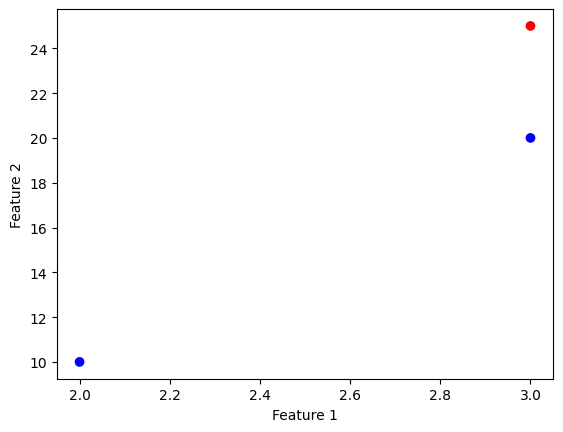

2     red
3    blue
4    blue
Name: Predicted Class, dtype: object


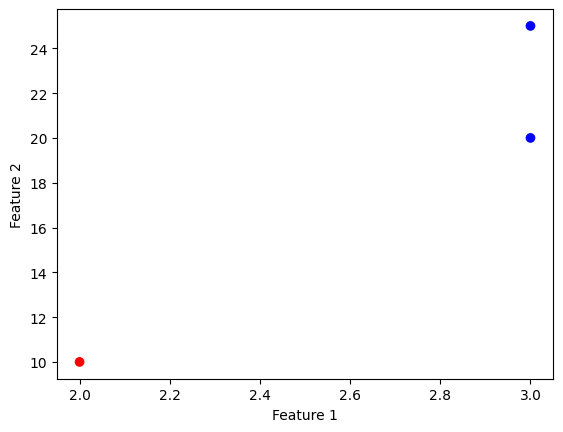

In [23]:
plt.scatter(test_data[X[0]], test_data[X[1]], c=test_data['Class'].map(colormap))

# Add labels and title
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.show()

print(test_data['Predicted Class'].map(colormap))
plt.scatter(test_data[X[0]], test_data[X[1]], c=test_data['Predicted Class'].map(colormap))

# Add labels and title
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.show()

## Compare Models

In [24]:
for model_name, scores in avg_scores.items():
      print(f"{model_name}:")
      print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
      print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
      print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
      print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
      print()

sklearn:
Precision: 0.2222 (+/- 0.1111)
Recall: 0.3333 (+/- 0.0000)
Accuracy: 0.3333 (+/- 0.0000)
F1 Score: 0.2500 (+/- 0.0833)

custom:
Precision: 0.2222 (+/- 0.1111)
Recall: 0.3333 (+/- 0.0000)
Accuracy: 0.3333 (+/- 0.0000)
F1 Score: 0.2500 (+/- 0.0833)

